#Movie Review Classifier using LSTM

####The objective of this project is to train a LSTM model using the IMDB Dataset which is freely available on kaggle and predict unseen reviews as either positive or negative.<br>

With this dataset we will see how to :
*  Explore Dqataset i.e perform Exploratory Data Analysis
* Pre-process text
* Split Dataset for training and testing purpose
* Tokenising and padding the dataset
* Build LSTM model
* Evaluating the model
* Prediction from the trained model 

### The IMDB Dataset
The IMDB sentiment classification dataset consists of 50,000 movie reviews from IMDB users that are labeled as either positive (1) or negative (0).The 50,000 reviews are split into 25,000 for training and 25,000 for testing. 

You can download and upload the dataset in your Google Drive from this [link ](https://drive.google.com/file/d/1-RsnyWWFrQaYhs5Vvl-P58WtakNbETbA/view?usp=sharing).<br>


We will use the following tools and libraries to implement this project. 

*   Tensorflow 
*   Numpy, Pandas
*   Matplotlib, Seaborn
*   NLTK 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import tensorflow as tf

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Load the Dataset from your GDRive account
data = pd.read_csv('/content/gdrive/MyDrive/Dataset/IMDB_Dataset.csv')

#Get an overview of the Datset by calling info method.
#You can see it says there are 2 columns present with 50000 Data points
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


#Explore the Dataset

A critical skill in building a good performing model is understanding and interpreting the given data i.e perform *Exploratory Data Analysis (EDA)*.

We can use *Pandas* to explore with *matplotlib* to visualize the data we have.



In [ ]:
#prints the first 5 row
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


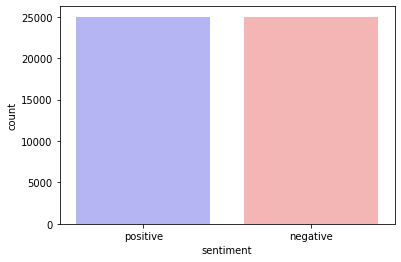

In [ ]:
# Group all the same class in the 'sentiment' column
sns.countplot(x="sentiment", data=data, palette="bwr")
plt.show()
#From the barplot it is clearly visible that the dataset is balanced i.e equal number of data points are present from positive and negative classes

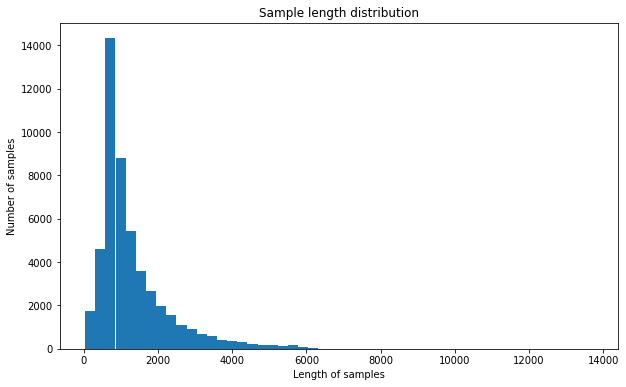

In [ ]:
# Get an idea how long the sentences are and how many of them are present
plt.figure(figsize=(10, 6))
plt.hist([len(sample) for sample in list(data['review'])], 50)
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()
#We can clearly see that most sentences are in range (500-1500)

Text(0.5, 0, 'words')

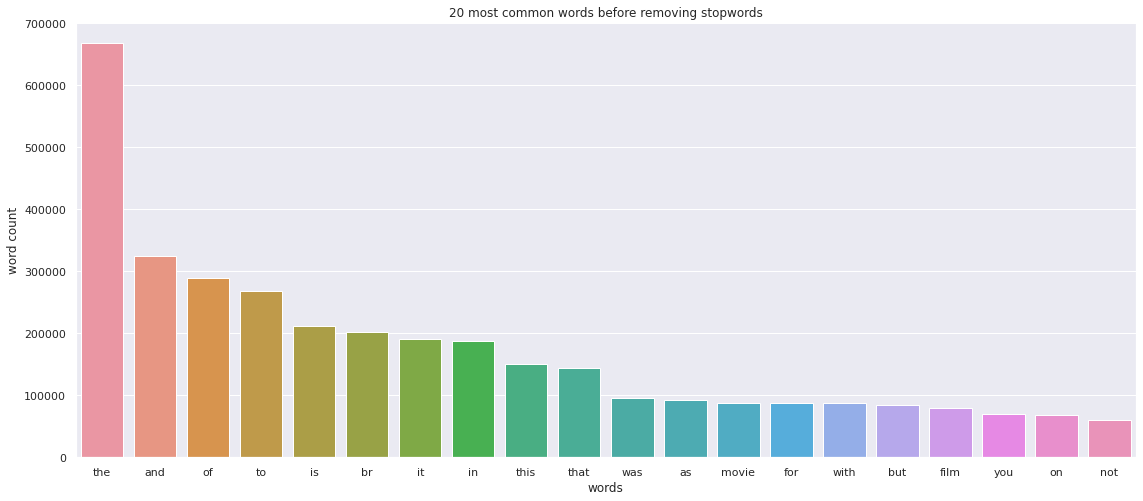

In [ ]:
# Let us find out the most common words used in this Dataset
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)  #forming a corpus to vectorize
    bag_of_words = vec.transform(corpus)  #creating bag of words from the corpus
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]  # get the number frequence of all unique words
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)  #
    return words_freq[:n]  #return first n words
common_words = get_top_n_words(data['review'], 20)

df1 = pd.DataFrame(common_words, columns = ['review' , 'count'])

sns.set(rc={'figure.figsize':(19,8)})

plot = sns.barplot(x = 'review', y = 'count', data = df1)
plot.set_title('20 most common words before removing stopwords')
plot.set_ylabel('word count')
plot.set_xlabel('words')



#Text Preprocessing 
By this time you would have realized that Deep learning at it's core is millions of Matrix Multilications and addition of matrices, hence only numbers can be NN's input.<br>
Here we are dealing with words and we need to figure out a way to represent each sentence as a sequence of numbers.<br>
We will see how to clean the data and represent them as a sequence of numbers!

In [ ]:
# Convert all the words in a sentence to smaller case.
data['review'] = data['review'].str.lower()

In [ ]:
#There might be remnant HTML strings when you scrape data from websites or take tweets from twitter, its necessary to remove them as they do not add any extra meaning to the sentence.
def remove_html_tags(text):
    """Remove html tags from a string"""
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

i =0
for strn in data['review']:
  data['review'][i] = remove_html_tags(strn)
  i +=1

In [ ]:
#Remove any Numeric characters present.
data['review'] = data['review'].apply(lambda x : re.sub(r"[^a-zA-Z0-9]", " ", x ))

In [ ]:
# Stopwords list from https://github.com/Yoast/YoastSEO.js/blob/develop/src/config/stopwords.js
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

Usually words classified as stopwords above, even if removed from the sentence won't affect or change the meaning of the sentence drastically, so it is safe to remove them so that the training time and pre-processing time can be saved.

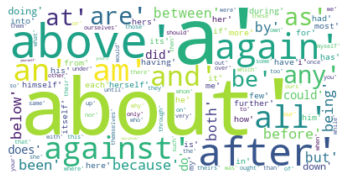

In [ ]:
##Let's take a look at the most common stopwords apprearing in our Dataset
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = str(stopwords)

wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#Remove stopwords from the review
i = 0
for strn in data['review']:
  for word in stopwords:
    token = " " + word + " "        #Identify the stopword.
    strn = strn.replace(token, " ") # replacing with empty space means basically removing it.
    strn = strn.replace("  ", " ")                  
  data['review'][i] = strn
  i += 1

Text(0.5, 0, 'words')

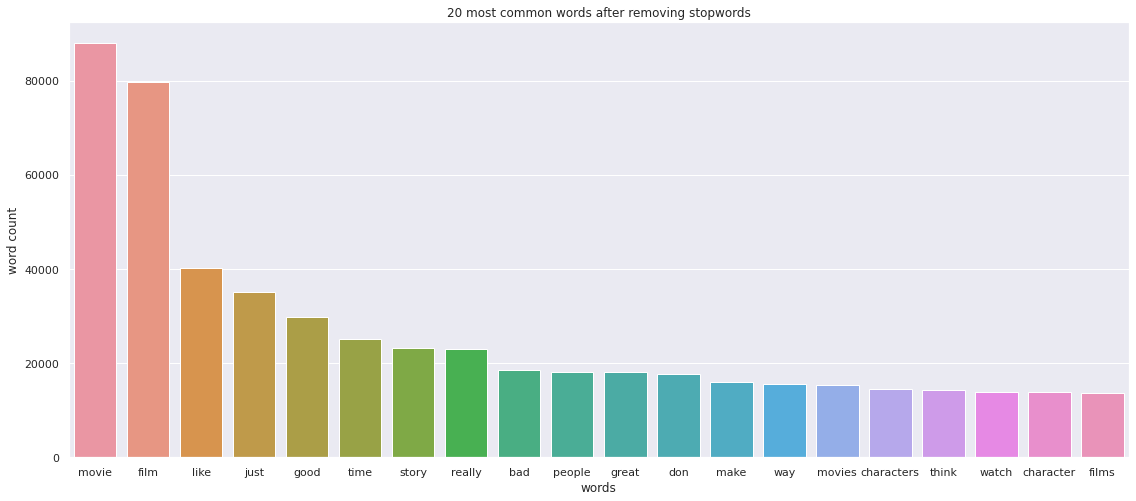

In [ ]:
# By plotting the same graph we can see that the most common words are no longer stopwords!

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(data['review'], 20)

df2 = pd.DataFrame(common_words, columns = ['review' , 'count'])

sns.set(rc={'figure.figsize':(19,8)})

plot = sns.barplot(x = 'review', y = 'count', data = df2)
plot.set_title('20 most common words after removing stopwords')
plot.set_ylabel('word count')
plot.set_xlabel('words')

#Splitting the Dataset
####At this stage it is time to split to our Dataset into Train and Test Datasets. It is not mandatory that you have to take 50% for testing and training, I choose to take 36k for training, 9k for validation and 5k for testing.

In [ ]:
# Using simple python indexing to seggregate
x = data['review'].iloc[0:45000 , ]
y = data['sentiment'].iloc[0:45000 , ]
x_test = data['review'].iloc[45000 : , ]
y_test = data['sentiment'].iloc[45000 : , ]

from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val = train_test_split(x,y, test_size = (0.2))

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)


(36000,)
(36000,)
(9000,)
(9000,)
(5000,)
(5000,)


#Tokenising and Padding the dataset


**Tokenization** is the process which helps us to represent sentence as sequence of numbers. A good explaination is given by this video, take a look!<br>
<r>


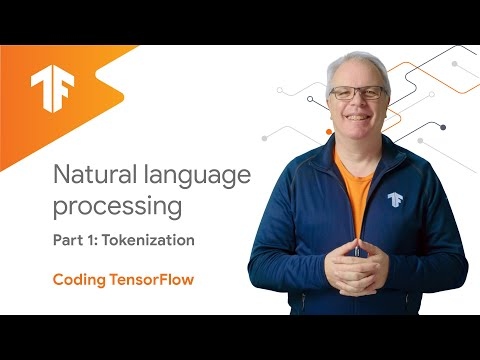

In [ ]:
#@title 
from IPython.display import YouTubeVideo
YouTubeVideo('fNxaJsNG3-s')

In [ ]:
#Create tokens of unique words present in x_train

from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")

tokenizer.fit_on_texts(x_train)       # Notice that only X_train is used

word_index = tokenizer.word_index
vocab_size = (len(word_index)) +1
vocab_size

90217

You can see that the tokenizer is made to fit on the *training dataset* the main reason being the test dataset is supposed to resemple input which the model will face in real-time. Therefore it should not have even a glimpse of training datset. So if we tokenize on the whole dataset and then split it the training dataset will have glimpse of test dataset and it may fail to generalize, hence the purpose of test dataset will not be served! This is known as *Data leakage*. So we should be careful enough to prevent data leakage through any means!

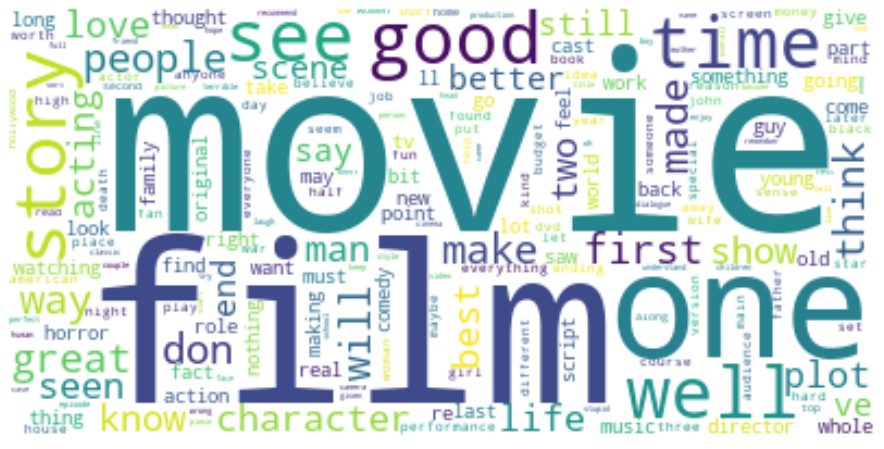

In [ ]:
# A visual representation of the vocabulary formed in the tokenization step.
vocab_list = (str(word_index.keys()))
vocab = vocab_list.replace(", ",'')
vocab = vocab.replace("''",' ')
vocab = vocab.replace("dict_keys(['<OOV> s",'')
vocab

wordcloud = WordCloud(background_color="white").generate(vocab)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Now that we have tokenized our sentences, we have to convert all the tokens to the same lenght i.e the input dimension of all data ppoints in the dataset should be made equal else *TensorFlow* will throw error at you.

Hence to achieve this *Sequencing* is used, the below video explains how it works and the code for the same.

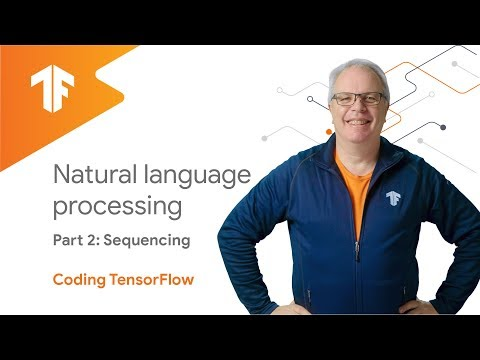

In [ ]:
#@title 
from IPython.display import YouTubeVideo
YouTubeVideo('r9QjkdSJZ2g')

In [ ]:
#Take a look at the above video to know why padding is necessary and how it should be done.
from keras.preprocessing.sequence import pad_sequences

x_train_sequences = tokenizer.texts_to_sequences(x_train)
x_train_padded = pad_sequences(x_train_sequences, padding='post',maxlen=1496)
x_val_sequences = tokenizer.texts_to_sequences(x_val)
x_val_padded = pad_sequences(x_val_sequences, padding='post',maxlen=1496)
x_test_sequences = tokenizer.texts_to_sequences(x_test)
x_test_padded = pad_sequences(x_test_sequences, padding='post',maxlen=1496)

print((x_train_padded).shape)
print((x_val_padded).shape)
print((x_test_padded).shape)

(36000, 1496)
(9000, 1496)
(5000, 1496)


As mentioned above, NN can only take numbers as it's input, therefore we need to labels i.e *positive* and *negative* into number representation.<br>
*Label Encoding* is a simple technique in which all the labels are assigned a number, in our project we have two classes, so each class gets assigned a number and it is represented through the same number.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Make copy to avoid changing original data 
label_y_train = y_train.copy()
label_y_val   = y_val.copy()
label_y_test  = y_test.copy()
# Transform categorical data into number representation
label_encoder = LabelEncoder()

label_y_train = label_encoder.fit_transform(label_y_train)
label_y_val   = label_encoder.transform(label_y_val)
label_y_test  = label_encoder.transform(label_y_test)


label_y_train = label_y_train.reshape(36000,1)
label_y_val   = label_y_val.reshape(9000,1)
label_y_test  = label_y_test.reshape(5000,1)

# positive is encoded as -> 1
# negative is encoded as -> 0

print(label_y_train.shape)
print(label_y_val.shape)
print(label_y_test.shape)


(36000, 1)
(9000, 1)
(5000, 1)


#Building the LSTM model

In [ ]:
#creating model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 55, input_length=1496),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(55,return_sequences =True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(55)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
# loss is binary_crossentropy as this is a binary classification problem
#There are varoius optimizers Adam is the best choice
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc'])
#you can see the model structure in the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1496, 55)          4961935   
_________________________________________________________________
bidirectional (Bidirectional (None, 1496, 110)         48840     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 110)               73040     
_________________________________________________________________
dense (Dense)                (None, 64)                7104      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 5,090,984
Trainable params: 5,090,984
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Decide how many times you want to pass the whole dataset through hemodel
num_epochs = 5
#This method starts the training
history = model.fit(x_train_padded, label_y_train, epochs=num_epochs, validation_data=(x_val_padded, label_y_val), verbose=2)

Epoch 1/5
1125/1125 - 309s - loss: 0.2065 - acc: 0.9231 - val_loss: 0.3273 - val_acc: 0.8599
Epoch 2/5
1125/1125 - 307s - loss: 0.1248 - acc: 0.9576 - val_loss: 0.3440 - val_acc: 0.8852
Epoch 3/5
1125/1125 - 305s - loss: 0.0620 - acc: 0.9812 - val_loss: 0.3467 - val_acc: 0.8893
Epoch 4/5
1125/1125 - 305s - loss: 0.0381 - acc: 0.9885 - val_loss: 0.4521 - val_acc: 0.8831
Epoch 5/5
1125/1125 - 306s - loss: 0.0250 - acc: 0.9928 - val_loss: 0.4343 - val_acc: 0.8843


In [ ]:
print(x_test_padded.shape)
print(label_y_test.shape)

(5000, 1496)
(5000, 1)


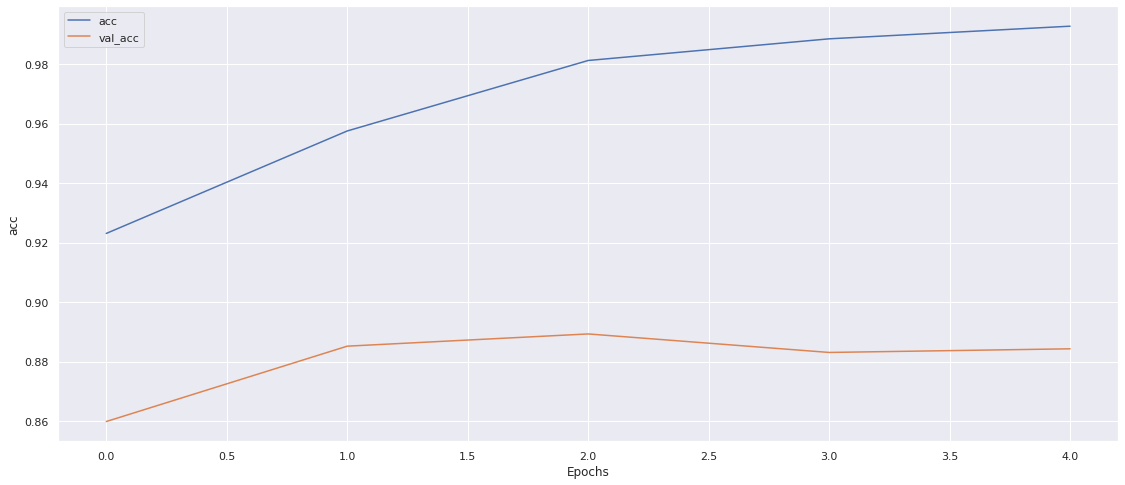

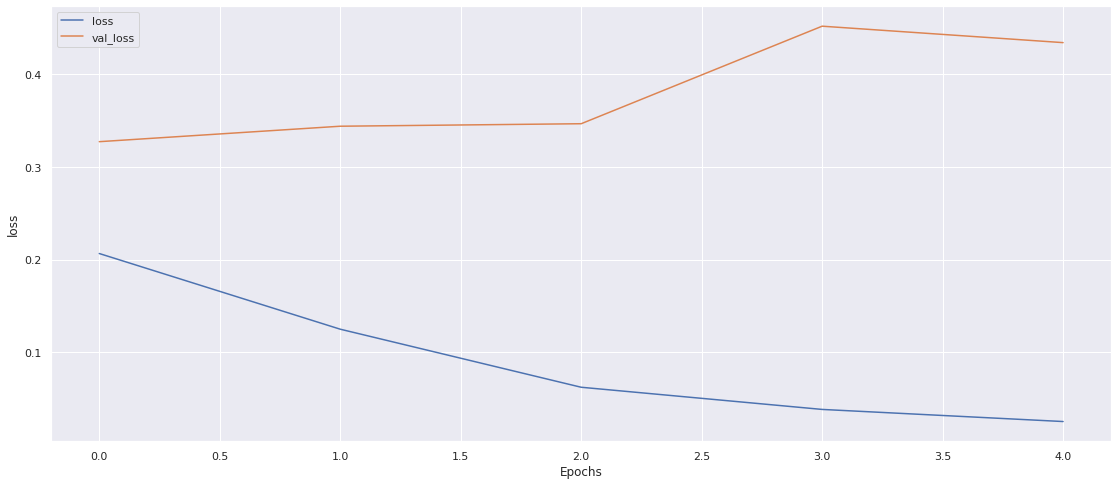

In [ ]:
import matplotlib.pyplot as plt

#Provides a visual representation of the accuracy 
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "acc")
plot_graphs(history, "loss")

# Evaluating the model

In [ ]:
#Evaluating with test dataset
model.evaluate(x_test_padded,label_y_test)

157/157 [==============================] - 15s 98ms/step - loss: 0.3982 - acc: 0.8912


[0.398207426071167, 0.8912000060081482]

In [ ]:
#while doing classification it is important to take a look at other metrics such as precision, recall etc
from sklearn.metrics import classification_report


print (classification_report(pred, label_y_test))

              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89      2464
         1.0       0.90      0.88      0.89      2536

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(pred, label_y_test)

array([[2225,  239],
       [ 305, 2231]])

In [ ]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(x_test_padded).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(label_y_test, y_pred_keras)

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

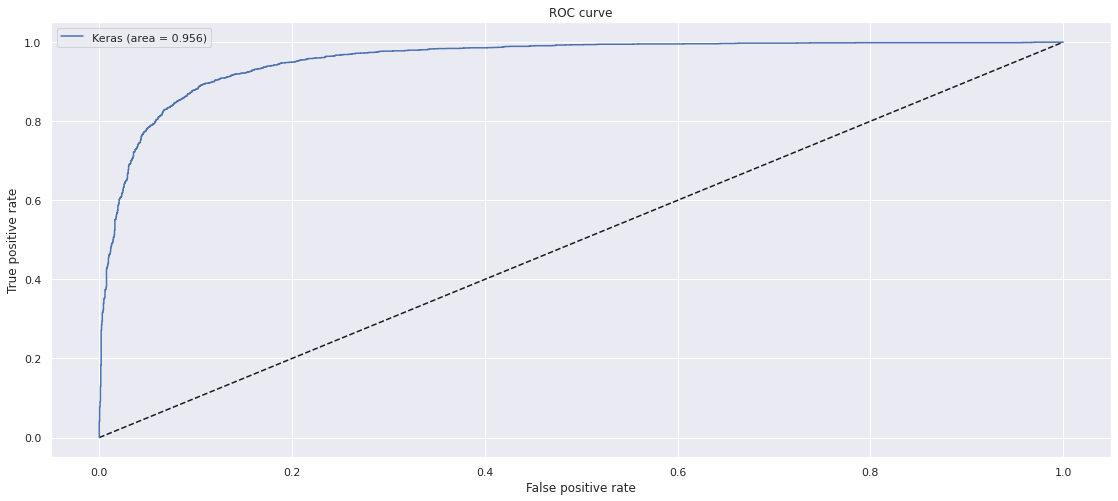

In [ ]:
#Evaluate ROC 
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#Prediction from the trained model 
 Now that we have our model ready, it is time that we feed our own input(sentences) and see how it performs on unseen or real world data

In [ ]:
x#These are the two sentences we intend to feed as input, we can clearly see that first input is positive and the latter one is negative, let's see if our model can recognize it
text = ['this movie took me to another world, was transported to another dimension', ' it  was complete waste of money and time']

#Note that we have to do same preprocessing steps to predict as the input to the model should be in a simimlar manner as to it was trained
text_sequence = tokenizer.texts_to_sequences(text)  #tokenize
text_padded = pad_sequences(text_sequence, padding='post',maxlen=1496)  #padding

#Now that it's in the required format we can send it to the model
prediction = model.predict(text_padded)  #model.predict() gives a single number between 0 and 1 which acts like the probability of positive and negative review.

output = np.array([])

#So to classify as output, if the *prediction* value is above 0.5 then it is classified as positive else negative.
for pred in prediction:
  output =np.append(output , 'positive' if pred>0.5 else 'negative')

print(output)
  

['positive' 'negative']


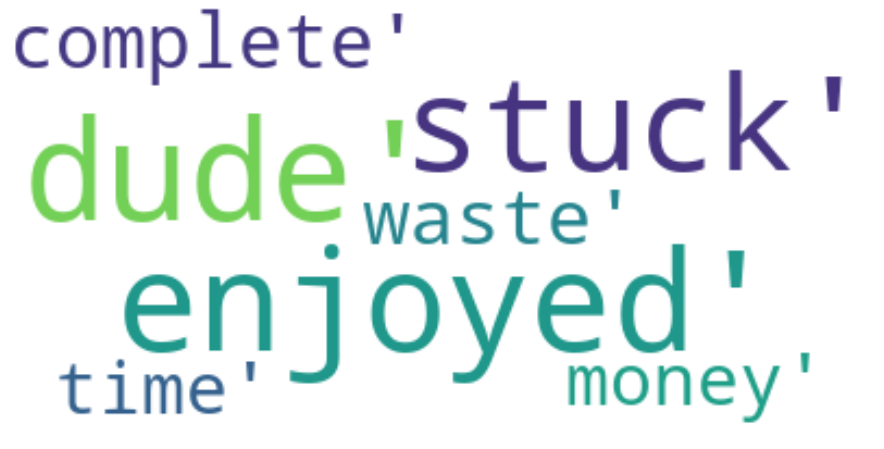

In [ ]:
#using wordcloud we can see the majority words in the output
cloud = []

for strn in text:
  sp = strn.split()
  for word in sp:
     if word not in stopwords:
       cloud.append(word)
cloud = (str(cloud))

wordcloud = WordCloud(background_color="white").generate(cloud)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()